In [36]:
import os
import argparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from datetime import datetime
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
from scipy import stats
import itertools

In [302]:
# For reproducibility, when running gridsearch or 50 subsample, set to None to measure stochasticity
seed_value = 1234

In [37]:

def str2boolean(s):
	if s == 'False':
		s_new = False
	else:
		s_new = True
	return s_new

In [38]:
# Config

toy=False
sample = 0 #which random subsample to run
pre_or_post = 'pre' 
plot=False

timestamp = datetime.today().strftime('%Y-%m-%d-%H-%M')
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/final_features/'
output_dir = f'./../../datum/reddit/output/supervised_umap/umap_cluster_{pre_or_post}_{timestamp}/'
print(output_dir)

./../../datum/reddit/output/supervised_umap/umap_cluster_pre_2020-06-20-08-09/


In [39]:
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')


In [40]:
try: os.mkdir(output_dir)
except: pass

In [3]:
# Or load from arguments
parser = argparse.ArgumentParser()
parser.add_argument('--job_array_task_id',
                    help='default: ${SLURM_ARRAY_TASK_ID} or 1. When using job arrays, this will be set by the bash script by ${SLURM_ARRAY_TASK_ID} or set to 1, which will be substracted below by 1 for zero indexing')
parser.add_argument('--plot', help='plot of each run')
parser.add_argument('--toy', help='run quickly with less labels, parameters and splits')
parser.add_argument('--pre_or_post', help='post, pre, 2019, 2018')

args = parser.parse_args()
if args.job_array_task_id != None:
	sample = int(args.job_array_task_id) - 1
    
if args.plot!=None:
	plot = str2boolean(args.plot)
    
if args.toy!=None:
	toy = str2boolean(args.toy)

if args.toy!=None:
	pre_or_post = str(args.pre_or_post)

    

NameError: name 'argparse' is not defined

In [41]:


# silence NumbaPerformanceWarning
import warnings
import numba
from numba.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


In [42]:
import pickle
def save_obj(obj, path ):
    with open(path , 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [190]:
subreddits = ['EDAnonymous',
 'addiction',
 'adhd',
 'alcoholism',
 'anxiety',
 'autism',
 'bipolarreddit',
 'bpd',
 'depression',
 'healthanxiety',
 'lonely',
 'ptsd',
 'schizophrenia',
 'socialanxiety',
 'suicidewatch']


In [457]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False,title = 'title', savefig_path = False,
                 centers= None, centers_labels = None,  plot_centroid_names = True, dists=None):

    plt.clf()
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
    palette =   sns.color_palette("husl", len(np.unique(y)))
    # Shuffle
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)
    
    data = pd.DataFrame(X_reduced, columns = ['x', 'y'])
    data['label'] = y
    color_order = np.unique(y)
    print(color_order)
#     color_order.sort()
    if centers_labels:
        legend=False
    else:
        legend=True
    g = sns.lmplot(data=data, x='x', y='y', hue='label', hue_order=color_order,
                   fit_reg=False, legend=legend,palette=palette, legend_out=True, scatter_kws={"s": 10})
    
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))

    # Centroids
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black',)
#         label='centroids')
    
    if centers_labels and plot_centroid_names:
        for i, label in enumerate(centers_labels):
            plt.text(x = centers[i,0], y = centers[i,1], s=label, fontsize=8)
    
    if title:
        plt.title(title)
#     plt.legend()
    
    if savefig_path:
        print('plotting...')
        plt.savefig(savefig_path+title.replace('/','-')+'.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [391]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True, plot_centroid_names = True):
    
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y_encoded)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)
    
    print('running kmeans...')
    # Set k to amount of subreddits
    k = len(np.unique(y))
    # Fit kmeans
    km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
    # Obtain euclidean distance between centroids

    # find centroids and labels
    data = pd.DataFrame(X_reduced, columns = ['x1', 'x2'])
    data['label'] = y

    centers = []
    centers_labels = list(np.unique(y))
    for sr in centers_labels:
        data_sr = data[data.label==sr]
        sr_centroid = data_sr[['x1','x2']].mean(axis=0)
        centers.append(sr_centroid)
    
    centers = np.array(centers)
    
    
    # Plot in 2D
    if plot:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path)
            
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers, centers_labels = centers_labels,plot_centroid_names = plot_centroid_names )
    if method == 'metric_learning':
        return X_reduced, X_reduced_test
    else:
        return X_reduced, centers, centers_labels

def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

## Load data with our without subsampling

In [193]:
def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2


In [458]:
def clean(df):
    # remove author duplicates and shuffle so we dont keep only first posts in time
    reddit_data = df.sample(frac=1) #shuffle
    reddit_data = reddit_data.drop_duplicates(subset='author', keep='first')
    reddit_data  = reddit_data [~reddit_data.author.str.contains('|'.join(['bot', 'BOT', 'Bot']))] # There is at least one bot per subreddit
    reddit_data = reddit_data[~reddit_data.post.str.contains('|'.join(['quote', 'QUOTE', 'Quote']))] # Remove posts in case quotes are long
    reddit_data = reddit_data.reset_index(drop=True)
    return reddit_data


def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):
    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder+subreddits[0]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)        
    #     Clean
    reddit_data = clean(reddit_data)
    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    if subreddits[0]=='COVID19_support' and pre_or_post == 'post':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]

    # Subsample to int or subsample float
    print(reddit_data.shape)
    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder +subreddits[i]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)
        # Clean
        new_data  = clean(new_data )
        if subreddits[i]=='COVID19_support' and pre_or_post == 'post':
              reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data



In [459]:
# reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = 5600,pre_or_post = 'pre')

# counts = reddit_data.groupby(["subreddit", "date"]).size().reset_index(name='count')
# print('counts per day:')
# for sr in subreddits:
#   counts_d = counts[counts.subreddit == sr].mean()
#   print(sr, ': ', np.round(float(counts_d),2))

## Find optimal params (optimize on silhouette score)

In [460]:
from scipy.spatial.distance import directed_hausdorff, euclidean


def hausdorff_distances(X,y, labels):
    len_labels = len(labels)
    # build empty df
    pairwise_distances_hausdorff = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)
    # pairwise_distances_euclidean = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)                          

    # Build df out of X
    df = pd.DataFrame(X)
    df.columns = ['x1', 'x2']
    df['label'] = y

    # Compute pairwise distance between labelled arrays 
    for row in range(len_labels):
        for col in range(len_labels):
            label_a = labels[row]
            label_b = labels[col]
            label_a_values = df[df.label==label_a][['x1','x2']].values
            label_b_values = df[df.label==label_b][['x1','x2']].values
            dist_hausdorff = directed_hausdorff(label_a_values,label_b_values)
            pairwise_distances_hausdorff.iloc[row,col]= dist_hausdorff[0]
    #         dist_euclidean = euclidean(label_a_values.mean(axis=0),label_b_values.mean(axis=0))
    #         pairwise_distances_euclidean.iloc[row,col]= dist_euclidean


    return pairwise_distances_hausdorff

## Run umap hyperparameter tuning OR 50 sample on 2019 data 

In [50]:
# I downloaded this script as .py and ran on cluster.  

In [51]:
# Load data
if pre_or_post == 'post':
    # Jan-April 2020
    subsample = 1350 #can set to False
    subreddits_edited = subreddits.copy()
    # todo: this will distort error from 2019:     
    #     subreddits_edited = ['COVID19_support']+subreddits


elif pre_or_post == 'pre':
    # all of 2019
    subsample = 2700
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2019':
    # jan-april 2019     
    subsample = 900
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2018':
    # jan-april 2018
    subsample = 450
    subreddits_edited = subreddits.copy()
    subreddits_edited.remove('EDAnonymous')

# Load data: define sample size
repeat_n = 50
sample_names = [f'{subsample}_{n}' for n in range(repeat_n)]

if toy:
    subsample = 20
    repeat_n = 2
    sample_sizes = [subsample] * repeat_n
    sample_names = [f'{subsample}_{n}' for n in range(repeat_n)]
    
#  sample is defined through jobid from argparse 
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'
reddit_data = load_reddit(subreddits_edited, data_folder=data_folder, subsample = subsample,pre_or_post = pre_or_post)

(6935, 350)
(2700, 350)
===
addiction
(4092, 350)
(2700, 350)
===
adhd
(16659, 350)
(2700, 350)
===
alcoholism
(3084, 350)
(2700, 350)
===
anxiety
(19945, 350)
(2700, 350)
===
autism
(4563, 350)
(2700, 350)
===
bipolarreddit
(2715, 350)
(2700, 350)
===
bpd
(10987, 350)
(2700, 350)
===
depression
(21161, 350)
(2700, 350)
===
healthanxiety
(4246, 350)
(2700, 350)
===
lonely
(11519, 350)
(2700, 350)
===
schizophrenia
(4272, 350)
(2700, 350)
===
socialanxiety
(12261, 350)
(2700, 350)
===
suicidewatch
(19906, 350)
(2700, 350)


In [52]:
# # Run umap hyperparameter tuning OR 50 sample on 2019 data
# # for i, name in zip(sample_sizes, sample_names):
# print('\n\n{} =========================================='.format(subsample))
# results = {}
# results_i = []
# results_i_dists = [] #euclidean
# results_i_dists_hausdorff = []
# results_i_centers = []
# # reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = i,pre_or_post = 'pre')
# features = list(reddit_data.columns)
# features = [n for n in features if n not in ['subreddit','author','date','post']]
# #   print('double check features: ',features)
# X = reddit_data[features].values
# y = reddit_data.subreddit.values

# method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
# annotate = False
# annotate_names = False
# run_Ntimesteps = 1# len(X)#len(X) #1,2 ... len(X) 
# color_code = y.copy()


# # Set up gridsearch
# n_dimensions =  [2,] #[4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
# n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
# min_dist = [0]  # [0,0.1,0.5,0.99] # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
# metrics = ['cosine'] # ['euclidean','cosine'] 
# repeat_n = 1
# repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
# scalers = [StandardScaler()]

# gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
# for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
#     print('\n{} out of {}'.format(j, len(gridsearch)))
#     print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
#     title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist)
#     print('running umap...')         
#     X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
#         color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
#         savefig_path = savefig_path, plot = plot)

#     print('runnning metrics...')
#     # compute euclidean distances
#     dists = euclidean_distances(centers)
#     dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
#     # hausdorff distance
    
#     dists_df_hausdorff = hausdorff_distances(X_reduced,y, subreddits)
#     # Compute silhouette score
#     sil_score = silhouette_score(X_reduced, y)
    
#     # centers
#     df_centers = pd.DataFrame(centers)
#     df_centers['labels'] = centers_labels     

#     # Compute convex hull
#     hull = ConvexHull(centers)
#     hull_area = hull.volume #volume is area in 2D
    
#     #     Append
#     results_i.append([metric,neighbor,dist,sil_score, hull_area])
#     results_i_dists.append(dists_df)
#     results_i_dists_hausdorff.append(dists_df_hausdorff)
#     results_i_centers.append(df_centers)


# results_gs = pd.DataFrame(results_i)
# results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
# results_gs = results_gs.sort_values('sil_score')
# # results[name] = results_gs
# timestamp = datetime.now().isoformat()
# results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')
# # euclidean
# results_gs_dists = pd.concat(results_i_dists)
# results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )
# # hausdorff
# results_gs_dists_hausdorff = pd.concat(results_i_dists_hausdorff)
# results_gs_dists_hausdorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_hausdorff_{timestamp}.csv', )
# # centers
# results_gs_centers = pd.concat(results_i_centers)
# results_gs_centers.to_csv(output_dir+f'run_{name}_umap_gs_centers_{timestamp}.csv', )
# print('done.')

In [53]:
# # fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

# fig, ax = plt.subplots(4,2, figsize=(12, 12))

# # idx = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],]

# cols_len = len(cols[1:])
# plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
# for col,i in zip(cols[1:], range(cols_len)):
#     df.plot(x="sample", y=col, kind="line", ax=ax.flat[i])
# # plt.figure(figsize=(20,20))
# fig.savefig(output_dir+'umap_gs.png')
    

## See how stable UMAP is across 2019 runs and resampling

In [444]:
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/'
input_dir = './../../datum/reddit/output/supervised_umap/umap_cluster_pre_2020-06-20-09-18/'
# Create output_dir
# timestamp = datetime.today().strftime('%Y-%m-%d-%H-%M')
output_dir = input_dir.replace('pre', 'post')

try: os.mkdir(output_dir)
except: pass


In [445]:
# # Obtain original sample size from which they were subsampled
# reddit_data = load_reddit(subreddits, data_folder=data_folder + 'final_features/', subsample = False,pre_or_post = 'pre')

# count = {}
# for sr in subreddits:
#     count_sr = reddit_data[reddit_data.subreddit==sr].shape[0]
#     count[sr]=str(np.round(count_sr/1000,1))+'k'

# count
    

In [446]:
# # Visually inspect how much they're moving: create a gif - 2019

# frame_dur = 1.5

# filenames = os.listdir(input_dir)
# filenames = [n for n in filenames if '.png' in n ][::5]


# import imageio

# images = list(map(lambda filename: imageio.imread(input_dir+filename), filenames))
# imageio.mimsave(input_dir+'supervised_umap.gif', images, format='GIF', duration=frame_dur)

### Load distances for all 50 runs to compute var and rank mean distance for each sr

In [447]:


dists_all = []
ranked_index = []
files = os.listdir(input_dir)
files = [n for n in files if '_dists_hausdorff_' in n ]
for file in files:
    df = pd.read_csv(input_dir+file, index_col=0)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)
    if len(np.unique(df.index)) < len(df.index):
        break
    dists_all.append(df.values)
    
    df_mean_ranked = df.mean()
    df_mean_ranked = df_mean_ranked.sort_values(0)
    df_mean_ranked_index = list(df_mean_ranked.index)
    ranked_index.append(df_mean_ranked_index)

dists_all = np.array(dists_all)

In [448]:
# # Append original sample size to subreddit name
# subreddits_new = []
# for sr in subreddits:
#     name_new = sr+' '+count.get(sr)
#     subreddits_new.append(name_new)

# subreddits_new

In [450]:
# Compute variance across 50 runs

dists_all_var = dists_all.std(axis=0)
dists_all_var = pd.DataFrame(dists_all_var)
dists_all_var.columns = subreddits
dists_all_var.index = subreddits
print('max:', dists_all_var.max().max())
dists_all_var



max: 11.547398352861121


,EDAnonymous,addiction,adhd,alcoholism,anxiety,autism,bipolarreddit,bpd,depression,healthanxiety,lonely,ptsd,schizophrenia,socialanxiety,suicidewatch
EDAnonymous,0.000000,5.262672,6.412949,8.127942,4.716519,4.464114,5.063632,7.238876,6.697497,4.436426,6.459835,8.353687,6.001658,6.268743,6.178404
addiction,6.189261,0.000000,5.714727,7.927308,4.929590,5.000460,3.418719,6.453751,3.912512,4.064578,5.733611,5.495777,4.382461,3.230144,4.518067
adhd,8.402227,5.097677,0.000000,8.590318,5.012935,4.875554,5.431481,6.609670,5.470689,7.158422,6.222264,9.111342,7.502420,6.919493,9.091899
alcoholism,7.414911,3.068311,9.997470,0.000000,5.566256,8.067632,4.442095,8.337799,8.022496,7.557252,7.855408,6.159433,7.904045,9.365025,7.958183
anxiety,7.822500,6.038099,8.540868,8.814543,0.000000,6.744873,5.405947,5.477527,5.967497,7.853431,7.301378,8.817834,8.142637,7.435177,9.194819
autism,9.026834,3.470387,9.094341,7.387935,5.161083,0.000000,6.002025,6.355657,7.198334,9.243234,7.036411,9.131109,8.223622,8.780272,8.646712
bipolarreddit,6.431232,5.461581,6.327587,8.023980,5.987857,6.090853,0.000000,5.941478,6.070757,6.771905,6.757657,7.245873,6.477325,4.227183,6.594494
bpd,6.196493,3.938944,8.607490,8.485912,5.867541,5.439966,3.821898,0.000000,5.155524,6.889983,6.024716,7.450014,6.384368,7.260066,6.961889
depression,9.917211,6.183422,8.919796,9.407239,6.281631,6.692565,5.958772,8.486014,0.000000,8.198449,7.644436,10.375190,8.796017,8.022115,8.071834
healthanxiety,7.819947,5.972887,7.714357,6.829937,4.497931,5.638066,3.623531,6.966008,6.165629,0.000000,6.814420,8.129154,7.221592,5.382666,7.809784


### Create a heatmap with median and IQR 

In [451]:
# Median
df_median = np.median(dists_all, axis=0)
df_median = pd.DataFrame(df_median)
df_median.columns = subreddits_new
df_median.index = subreddits_new
print('max:', df_median.max().max())
df_median

max: 29.041715006246807


,EDAnonymous 6.9k,addiction 4.1k,adhd 16.7k,alcoholism 3.1k,anxiety 19.9k,autism 4.6k,bipolarreddit 2.7k,bpd 11.0k,depression 21.2k,healthanxiety 4.2k,lonely 11.5k,ptsd 4.5k,schizophrenia 4.3k,socialanxiety 12.3k,suicidewatch 19.9k
EDAnonymous 6.9k,0.000000,17.342536,15.159318,20.750676,17.698359,16.491345,19.639990,13.404334,13.491462,15.899426,17.000319,12.983053,15.503947,16.116678,17.577337
addiction 4.1k,14.978457,0.000000,15.229746,15.150512,15.376566,13.393077,14.927741,13.440486,14.242904,13.661942,13.084944,16.427524,15.540347,16.632161,16.038065
adhd 16.7k,14.874319,16.998600,0.000000,18.033302,15.914500,12.949715,16.881717,14.021602,15.706515,14.908636,16.649736,17.433555,16.320270,13.747240,15.036139
alcoholism 3.1k,25.864710,16.980138,25.655713,0.000000,18.530718,10.924972,21.609366,12.040270,18.094554,24.351905,19.791595,29.041715,26.663765,17.140173,24.723975
anxiety 19.9k,19.036253,16.337291,19.902590,14.796862,0.000000,11.638776,19.937818,13.536417,15.766689,14.317529,17.432165,26.266016,19.679159,15.525775,19.442628
autism 4.6k,23.401119,16.972128,22.332182,13.309271,16.043560,0.000000,20.681498,13.656799,16.796165,21.981616,17.986980,27.511472,25.046067,16.814892,23.072102
bipolarreddit 2.7k,9.637385,10.111044,11.197712,12.150563,9.878749,6.962695,0.000000,10.014996,8.386816,7.995573,10.472042,13.419633,9.456535,10.754753,9.086148
bpd 11.0k,23.505437,17.233217,24.585625,17.484414,18.806815,16.035578,21.914806,0.000000,16.915203,21.208094,18.637487,27.016130,24.111817,18.780256,23.020286
depression 21.2k,16.136981,16.637045,16.590658,17.738720,16.313438,14.701289,20.222999,11.753072,0.000000,16.624659,17.294256,20.369718,18.697249,16.095022,19.670786
healthanxiety 4.2k,14.853437,16.301545,15.661882,19.027275,12.433775,15.631468,17.995034,15.121444,16.686921,0.000000,16.307373,17.767114,14.211774,17.344275,18.363235


In [452]:
from scipy.stats import iqr
# IQR
df_iqr = iqr(dists_all, axis=0)
df_iqr = pd.DataFrame(df_iqr)
df_iqr.columns = subreddits_new
df_iqr.index = subreddits_new
print('max:', df_iqr.max().max())
df_iqr

max: 21.08471434571117


,EDAnonymous 6.9k,addiction 4.1k,adhd 16.7k,alcoholism 3.1k,anxiety 19.9k,autism 4.6k,bipolarreddit 2.7k,bpd 11.0k,depression 21.2k,healthanxiety 4.2k,lonely 11.5k,ptsd 4.5k,schizophrenia 4.3k,socialanxiety 12.3k,suicidewatch 19.9k
EDAnonymous 6.9k,0.000000,7.372043,7.037008,8.535904,6.884968,6.629671,7.347930,7.662246,11.729836,3.977685,6.961465,9.637991,6.474818,8.320642,6.281545
addiction 4.1k,6.696927,0.000000,6.243333,7.476354,5.150472,5.682801,4.754257,5.134843,5.654311,5.363854,7.754591,8.333607,5.316973,3.520834,4.553838
adhd 16.7k,12.741198,6.819478,0.000000,8.930464,8.340010,5.548285,7.285283,8.602724,6.477472,11.627176,8.172094,15.989290,13.896896,6.762607,12.921127
alcoholism 3.1k,9.278730,2.896351,16.281590,0.000000,6.353327,9.829188,2.611761,11.147217,14.125784,6.685598,8.512091,5.212771,12.298786,17.168711,9.074460
anxiety 19.9k,13.077746,8.904609,12.235991,7.842085,0.000000,6.626116,7.853296,7.603618,10.469663,13.444175,9.145277,13.392757,15.814396,10.955446,14.565883
autism 4.6k,13.467459,2.745364,16.996111,7.296611,8.398082,0.000000,5.143086,7.765877,13.023545,15.798582,10.996859,10.818439,13.134715,15.639987,10.492998
bipolarreddit 2.7k,7.314687,7.227506,5.935348,9.547766,7.507849,5.676612,0.000000,6.976554,3.599379,9.117906,7.692835,10.687622,7.193200,3.977111,7.692643
bpd 11.0k,10.496789,4.399623,15.271166,10.785114,6.823641,7.265206,2.878975,0.000000,9.090147,10.747247,7.315194,9.329138,11.363418,12.872591,10.644002
depression 21.2k,16.898100,6.773333,13.555019,11.880347,7.922589,8.452059,9.502661,9.870354,0.000000,13.407513,9.829921,17.197564,14.747254,10.882937,11.498825
healthanxiety 4.2k,7.444808,8.326232,12.261395,9.580726,5.363295,8.295728,3.275676,9.684986,11.293009,0.000000,8.075778,10.226441,9.748504,6.338983,12.910350


In [453]:
# Sort by sum of IQR 
sorted_iqr = list((df_iqr+df_iqr.T).sum().sort_values().index)

def reorder_index_cols(df, ordered_list):
    df = df.reindex(ordered_list)
    df = df[ordered_list]
    return df
    
df_median = reorder_index_cols(df_median, sorted_iqr)
df_iqr = reorder_index_cols(df_iqr, sorted_iqr)




<Figure size 9000x4500 with 0 Axes>

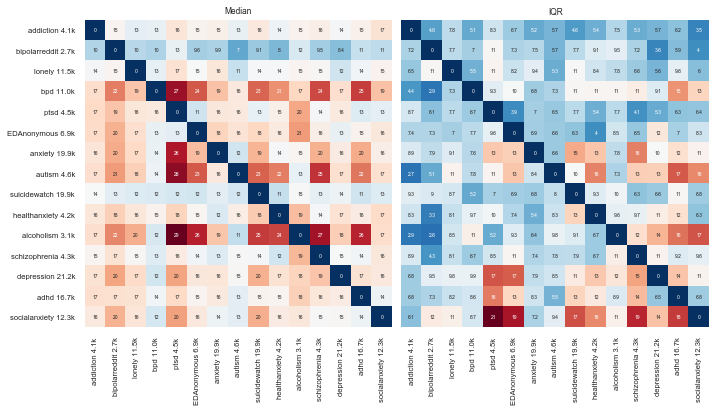

In [454]:
# Heatmap
sns.set(font_scale=0.7)
fontsize = 5
plt.figure(figsize=(30,15), dpi= 300, facecolor='w', edgecolor='k')
f, axes = plt.subplots(1, 2, sharey=True)

# plt.subplot(1, 2, 1)
ax = sns.heatmap(df_median, ax=axes[0],cmap = 'RdBu_r', annot=True,annot_kws={"fontsize":fontsize}, cbar=False)

axes[0].title.set_text('Median')
axes[0].set(adjustable='box', aspect='equal')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.subplot(1, 2, 2)
ax = sns.heatmap(df_iqr, ax=axes[1], cmap = 'RdBu_r', annot=True, annot_kws={"fontsize":fontsize},cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
axes[1].title.set_text('IQR')
axes[1].set(adjustable='box', aspect='equal')
plt.tight_layout()
plt.savefig(output_dir+'heatmap_dists.png', dpi=300)


## 2020: Build X, y by grouping data by timestep (e.g., 15 days) and run UMAP

In [455]:
# Random subsamplsubring may create reproducibility problems
subsample = 1300
reddit_data = load_reddit(subreddits, data_folder=data_folder+'final_features/', subsample = subsample,pre_or_post = 'post')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
timestep = 15
days = np.unique(reddit_data.date)

X = [] #shape (weeks, posts balanced by subreddits except COVID19_support, features)
y = []
for i in range(0,len(days),timestep)[:-1]: #remove last window cause it will have < timestep
  days_week = days[i:i+timestep]
  df_week = reddit_data[reddit_data.date.isin(days_week)]
  df_week_feature_cols = df_week[features].values
  df_week_y = list(df_week.subreddit)
  X.append(df_week_feature_cols)
  y.append(df_week_y)

X_timesteps = np.array(X)
y_timesteps = np.array(y)
days_week = days[::timestep]

(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)


In [456]:
np.save(output_dir+'X_timesteps.npy',X_timesteps)
np.save(output_dir+'y_timesteps.npy',y_timesteps)

timesteps = X_timesteps.shape[0]
print(f'samples: {X_timesteps[2].shape}')
print(f'days: {len(days)}')
print(f'windows: {len(days)/timestep}')
print(f'timesteps: {timesteps}')
print(f'days per timestep: {timestep}')
print(f'samples per timestep: {1350/timesteps}')

samples: (2849, 346)
days: 111
windows: 7.4
timesteps: 7
days per timestep: 15
samples per timestep: 192.85714285714286


### Compute UMAP and measure distances for each timestep

In [461]:
plot = True

savefig_path = output_dir


0 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely' 'ptsd'
 'schizophrenia' 'socialanxiety' 'suicidewatch']
plotting...
runnning metrics...

1 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely' 'ptsd'
 'schizophrenia' 'socialanxiety' 'suicidewatch']
plotting...
runnning metrics...

2 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxie

<Figure size 720x504 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

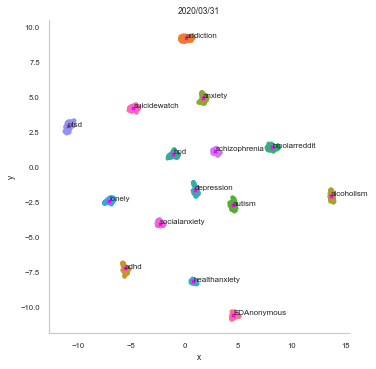

In [462]:
# Run: this is reproducible if UMAP has seed_value=1234, but it will change with subsampling above

name = subsample
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_hausdorff = []
results_i_centers = []
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
# X = reddit_data[features].values
# y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
plot_centroid_names=True
annotate = False
annotate_names = False
run_Ntimesteps = len(X_timesteps)# len(X)#len(X) #1,2 ... len(X) 


for i, (X_i, y_i) in enumerate(zip(X_timesteps[:run_Ntimesteps],y_timesteps[:run_Ntimesteps])):
    print('\n{} out of {}'.format(i, run_Ntimesteps))
    start_day = days_week[i].replace('/', '-')
    start_day = f'{start_day}'
    color_code = y_i.copy()
    # Set up gridsearch
    n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['cosine'] #,'cosine'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):

        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
        title = f'{start_day}'.replace('-','/')
        print('running umap...')         
        X_reduced, centers, centers_labels  = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, 
                                                       neighbor = neighbor , dist=dist, metric=metric, 
                                                       color_code = color_code, annotate_names = annotate_names, 
                                                       annotate = annotate, title=title,
                                                       savefig_path = savefig_path, plot = plot, 
                                                       plot_centroid_names=plot_centroid_names)

        print('runnning metrics...')
        # compute euclidean distances
        dists = euclidean_distances(centers)
        dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
        # hausdorff distance

        dists_df_hausdorff = hausdorff_distances(X_reduced,y_i, subreddits)
        # Compute silhouette score
        sil_score = silhouette_score(X_reduced, y_i)

        # centers
        df_centers = pd.DataFrame(centers)
        df_centers['labels'] = centers_labels     

        # Compute convex hull
        hull = ConvexHull(centers)
        hull_area = hull.volume #volume is area in 2D

        #     Append
        results_i.append([metric,neighbor,dist,sil_score, hull_area])
        results_i_dists.append(dists_df.values)
        results_i_dists_hausdorff.append(dists_df_hausdorff.values)
        results_i_centers.append(df_centers.values)

results_i_dists_hausdorff = np.array(results_i_dists_hausdorff)
        
# general results
results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores.csv')
# euclidean
np.save(output_dir+f'run_{name}_umap_gs_dists.npy',results_i_dists)
# hausdorff
np.save(output_dir+f'run_{name}_umap_gs_dists_hausdorff.npy',results_i_dists_hausdorff)
# centers
np.save(output_dir+f'run_{name}_umap_gs_centers.npy',results_i_dists_hausdorff)
print('done.')

### Visually inspect which subreddits are becoming closer with a line 
(this won't be useful because there are only 7 timesteps to fit the line, but it's good for inspection)

In [393]:
# Or fit a polynomial
def polyfit(x, y, degree):
    results = {}

    coeffs = numpy.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = numpy.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [394]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
degree = 3

df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y

weights = np.polyfit(x, y, degree)
model = np.poly1d(weights)
results = smf.ols(formula='y ~ model(x)', data=df).fit()


In [395]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [396]:
# polynomial = False
# savefig =True
# try: os.mkdir(output_dir+'trends/')
# except: pass


# sns.set_style("whitegrid", {'axes.grid' : False})
# plt.figure(figsize=(15,15), dpi= 80, facecolor='w', edgecolor='k')




# results_slope = {}
# for sr_title in subreddits:
#     results_slope[sr_title] = []
    
# results_p_value = {}
# for sr_title in subreddits:
#     results_p_value[sr_title] = []
    
# # todo: add text in plot

# color = 'hls' #hls husl
# palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
# sns.palplot(sns.color_palette(color, len(subreddits)))
# plt.show()

# for i, sr_title in enumerate(subreddits):
#     print(sr_title)
#     plt.clf()
#     plt.figure()
#     for j,sr_line in enumerate(subreddits):
#         x = days_week[:-1] #last window is removed becuase < timestep
#         x_digits = range(len(x))
#         y = results_i_dists_hausdorff[:,j,i]
#         y = zscore(y)
#         if polynomial:
#             if str(y[0]) =='nan':
#                 r_value, p_value = np.nan, np.nan
#                 continue
#             df = pd.DataFrame(columns=['y', 'x'])
#             df['x'] = x_digits
#             df['y'] = y
#             weights = np.polyfit(x_digits, y, polynomial) #polynomial=degree
#             model = np.poly1d(weights)
#             results = smf.ols(formula='y ~ model(x)', data=df).fit()
#             p_value = results.pvalues[1]
#             r2 = results.rsquared
#             summary = results.summary()
#         else:
#             # linear             
#             slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)            
#             sns.lineplot(x, x_digits*slope + intercept, label = sr_line, color=next(palette))
#             sns.lineplot(x, y,alpha=0.2)
#             results_slope[sr_title].append(slope * r_value**2)
#             results_p_value[sr_title].append(p_value)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.title( sr_title)
#     plt.xlabel('time')
#     plt.xticks(rotation=70)
#     plt.ylim((-2,2))
#     plt.ylabel('Hausdorff distance (z-score)')
#     if savefig:
#         plt.tight_layout()
#         plt.savefig(output_dir+f'/trends/{sr_title}.png', dpi=300)
#     plt.show()

##### We see healthanxiety, most are becoming similar towards the end.

### Here I tried to measure significance of slope but then realized there are only 7 timesteps, won't be significant after multiple comparison correction

In [397]:
# # Make DFs
# results_slope
# df_slope_r2 = pd.DataFrame(results_slope)
# df_slope_r2.index = subreddits
# df_slope_r2.columns = subreddits
# df_p_value = pd.DataFrame(results_p_value)
# df_p_value.index = subreddits
# df_p_value.columns = subreddits
# df_p_value


In [398]:
# # Extract tril
# def extract_tril(df):
#     df_tril = np.tril(df,k=0)
#     df_tril[df_tril == 0] = np.nan
#     df_tril = pd.DataFrame(df_tril, columns=df.columns, index=df.index)
#     return df_tril

# df_p_value_tril = extract_tril(df_p_value)
# df_slope_r2_tril = extract_tril(df_slope_r2)
# df_p_value_tril
    

In [399]:
# import math
# pvals = df_p_value_tril.values.flatten()
# print(len(pvals))
# pvals = [n for n in pvals if n == n]
# print(len(pvals))

In [400]:
# reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
# np.sum(reject)

In [401]:
# def multiple_comparisons(df_slope_r2, df_p_value):   
#     pvals = df_p_value_tril.values.flatten()
#     pvals = [n for n in pvals if n == n]
    
#     # Obtain mask of non-significant results
#     pvals= df_p_value.values.flatten() 
#     reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

#     # Create mask with significant results
#     reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
#     df_shape = df_p_value.shape # reshape to this shape
#     df_reject = pd.DataFrame(reject_opp.reshape(df_shape))
#     df_reject.columns = df_slope_r2.columns
#     df_reject.index = df_slope_r2.index
#     print('Significant results: ',np.sum(reject)/len(reject))
#     return df_slope, df_reject


In [402]:

# # Plot
# plt.clf()
# fontsize = 5
# plt.figure(figsize=(4,4), dpi= 150, facecolor='w', edgecolor='k')
# ax = sns.heatmap(df_slope_r2.round(2), annot=True,cmap = 'RdBu_r',vmin=-0.25, vmax=.25, cbar=False,annot_kws={"fontsize":fontsize})
# plt.xticks(rotation=90, fontsize=fontsize)
# plt.yticks(rotation=0, fontsize=fontsize)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.tight_layout()
# plt.savefig(output_dir+'/trends/heatmap.png',dpi=300)



### Compute percentiles with regards to 2019 pre data

In [403]:
input_dir

'./../../datum/reddit/output/supervised_umap/umap_cluster_post_2020-06-20-09-18/'

In [404]:
# Either re-run above or load for reproducibility
input_dir = './../../datum/reddit/output/supervised_umap/umap_cluster_post_2020-06-20-09-18/'
results_i_dists_hausdorff = np.load(input_dir+'run_1300_umap_gs_dists_hausdorff.npy')


In [405]:
# For each timestep, pairwise distance between clusters
results_i_dists_hausdorff.shape

(7, 15, 15)

In [406]:
# Choose subreddits for the example
print(subreddits)
sr_example_a = 'healthanxiety' 
sr_example_b = 'EDAnonymous'
sr_example_index = subreddits.index(sr_example_b)
sr_example_index

['EDAnonymous', 'addiction', 'adhd', 'alcoholism', 'anxiety', 'autism', 'bipolarreddit', 'bpd', 'depression', 'healthanxiety', 'lonely', 'ptsd', 'schizophrenia', 'socialanxiety', 'suicidewatch']


0

In [407]:
# Percentiles with regards to 2019
distance_3D_by_subreddit = []
percentile_3D_by_subreddit = []

# To plot an example:
distribution_2019_healthanxiety = []
distances_2020 = []

for sr_i in range(len(subreddits)):
    # sr_i = 4
    sr = subreddits[sr_i]     # eg health anxiety     
    check = sr
    # create df where I insert the distance 
    distance_df_sr = np.zeros(results_i_dists_hausdorff.shape[:2]).T # shape (timesteps,14)
    # create df where I insert what percentile the distance is with regards to 2019 data     
    percentile_df_sr = np.zeros(results_i_dists_hausdorff.shape[:2]).T # shape (timesteps,14)
    for timestep_i, timestep_df in enumerate(results_i_dists_hausdorff):
        # timestep_df has shape (14,14), pairwise dist for 1 timestep
        distances_sr = timestep_df[:,sr_i] #extract distances between this sr and other ones, the same as [sr_i, :] cause it's symmetrical
        for distance_i in range(len(distances_sr)):   
            distance_2020 = distances_sr[distance_i]             
            distance_df_sr [distance_i,timestep_i] = distance_2020
            #             
            distribution_2019 = dists_all[:,distance_i,sr_i]
            percentile = stats.percentileofscore(distribution_2019, distance_2020)
            percentile_df_sr [distance_i,timestep_i] = percentile        
            if  sr == sr_example_a and distance_i == sr_example_index:
                # For example plot                 
                distances_2020.append(distance_2020)
                distribution_2019_healthanxiety.append(distribution_2019)
    percentile_3D_by_subreddit.append(percentile_df_sr)
    distance_3D_by_subreddit.append(distance_df_sr)


percentile_3D_by_subreddit = np.array(percentile_3D_by_subreddit)



In [408]:
timesteps = days_week[:-1]


In [409]:
distribution_2019_healthanxiety = distribution_2019_healthanxiety[0] #I append it 7 times, but they're all the same

In [410]:
# to add to plot mention of covid19
add_covid19_mentions = False
covid_mean = np.array([1.37600246e-04, 9.57345045e-05, 1.19084550e-04, 1.38857552e-04,
       1.58399398e-04, 1.46508084e-04, 1.36883143e-04, 7.28435534e-05,
       8.05822045e-05, 1.04981156e-04, 1.99514315e-04, 3.97653861e-04,
       8.49297062e-04, 8.82636594e-04, 6.32921459e-04, 4.41946499e-04,
       5.12115236e-04, 3.28384094e-04, 4.61536461e-04, 3.40176205e-04,
       4.20744113e-04, 2.27834173e-04, 4.18033059e-04, 5.03355905e-04,
       4.41112974e-04, 1.82477636e-04, 3.91469570e-04, 3.59483858e-04,
       6.96401914e-04, 6.60079615e-04, 1.36545814e-03, 2.53557029e-04,
       5.30087844e-04, 3.06258723e-04, 1.10060493e-03, 1.75229626e-03,
       3.82335341e-03, 3.54900845e-03, 4.70985334e-03, 3.59627607e-03,
       4.07187859e-03, 3.96221607e-03, 4.53415672e-03, 3.52455265e-03,
       3.13137661e-03, 2.71011345e-03, 3.16281317e-03, 2.79342252e-03,
       2.83837582e-03, 2.29320931e-03, 2.45448753e-03, 2.89407344e-03,
       2.31492345e-03, 2.16047706e-03, 2.07815072e-03, 2.13970058e-03])

x_covid = range(8)
y_covid = covid_mean[::7][:8]*10000
print(len(y_covid))

8


In [411]:
output_dir

'./../../datum/reddit/output/supervised_umap/umap_cluster_post_2020-06-20-09-18/'

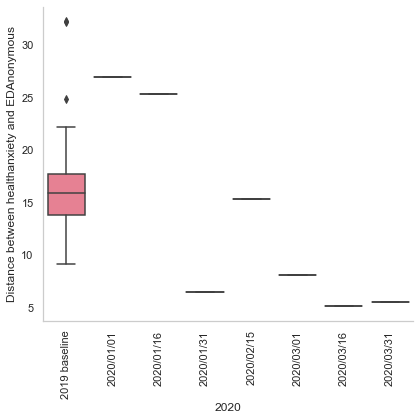

In [412]:
sns.set(rc={'figure.figsize':(6,6)}, font_scale =1, palette=sns.color_palette("husl", 7))
sns.set_style("white", {"axes.edgecolor": ".8"})

y = list(distribution_2019_healthanxiety) 

x = ['2019 baseline']*50   

for i in range(len(timesteps)):
#     date = timesteps[i].replace('2020/', '')
#     date_new = date.replace('/', '-')
    date_new = timesteps[i]
#     date_new = date+'-'+date[:3]+str(int(date[-2:])+15)
    x = x + [date_new]*50
    y = y + [distances_2020[i]]*50
    

sns.boxplot(x=x,y=y, palette='husl')
sns.despine()
plt.xticks(rotation=90)
plt.xlabel('2020')
plt.ylabel(f'Distance between {sr_example_a} and {sr_example_b}')



if add_covid19_mentions:
    sns.lineplot(x=x_covid, y = y_covid, c='k')
plt.tight_layout()
plt.savefig(output_dir+'example_distance_distribution.png', dpi=400)

### Plot distances

In [413]:
percentile_3D_by_subreddit.shape

(15, 15, 7)

In [414]:
# Set cutoff for masking
percentile_non_outliers = (percentile_3D_by_subreddit < 95) & (percentile_3D_by_subreddit > 5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<Figure size 600x600 with 0 Axes>

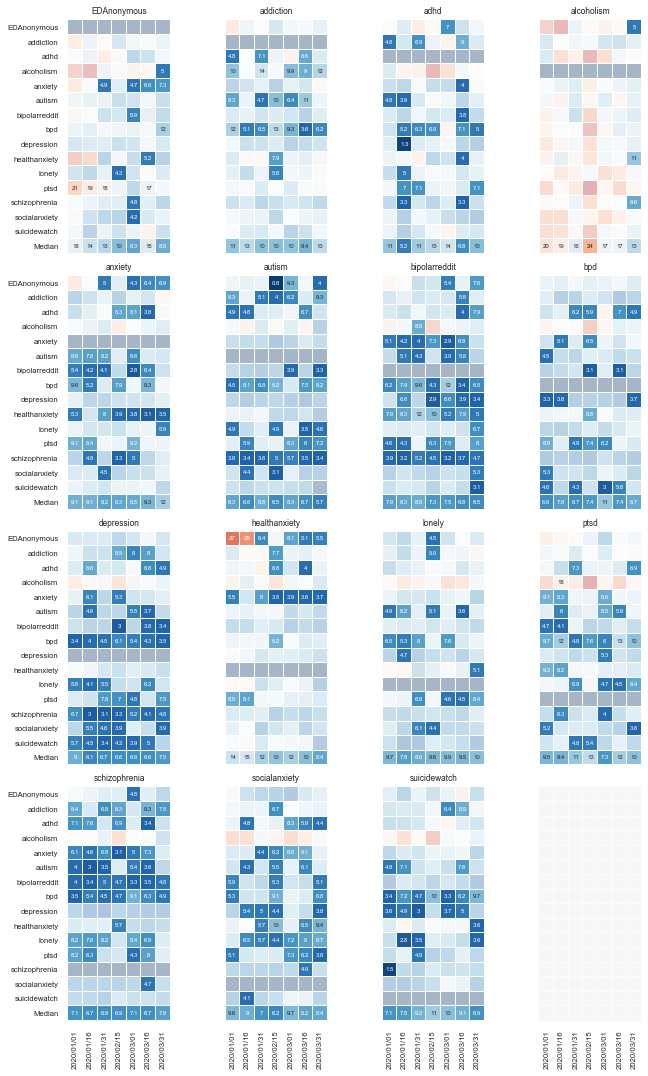

In [415]:
savefig = True 

cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.65)

# def plot_timestep_heatmaps(df, output_filename):
sns.set(font_scale=0.7)
fontsize = 6
dpi=100
plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15),)
axes = [n for i in axes for n in i]

median_percentiles ={}

for i, ax in enumerate(axes):
    print(i)
    if i in [15]:
        df = np.ones((len(subreddits),7))
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = np.ones(7)

        hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r',mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.set(adjustable='box', aspect='equal')
    else:
        sr = subreddits[i]
        df = pd.DataFrame(distance_3D_by_subreddit[i], columns = timesteps, index=subreddits)
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = df.median()
        median_percentiles[sr] = np.array(df.median())

        # outliers         
        df_outliers = percentile_non_outliers[i]
        df_outliers = np.concatenate([df_outliers, [np.zeros(df.shape[1])]],axis=0)

        
        sns.heatmap(df.round(1), cbar=False,cmap = cmap, square=True, ax=ax, 
                         vmin=0, vmax=35,linewidths=0)
        hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = cmap,mask =df_outliers, square=True, ax=ax, 
                         annot_kws={"fontsize":fontsize},vmin=0, vmax=35,linewidths=0.01)
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(sr)
        ax.set(adjustable='box', aspect='equal')



plt.tight_layout()
if savefig:
    plt.savefig(output_dir+f'/distances_all.png', dpi=400)
    


### Plot percentiles

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<Figure size 600x600 with 0 Axes>

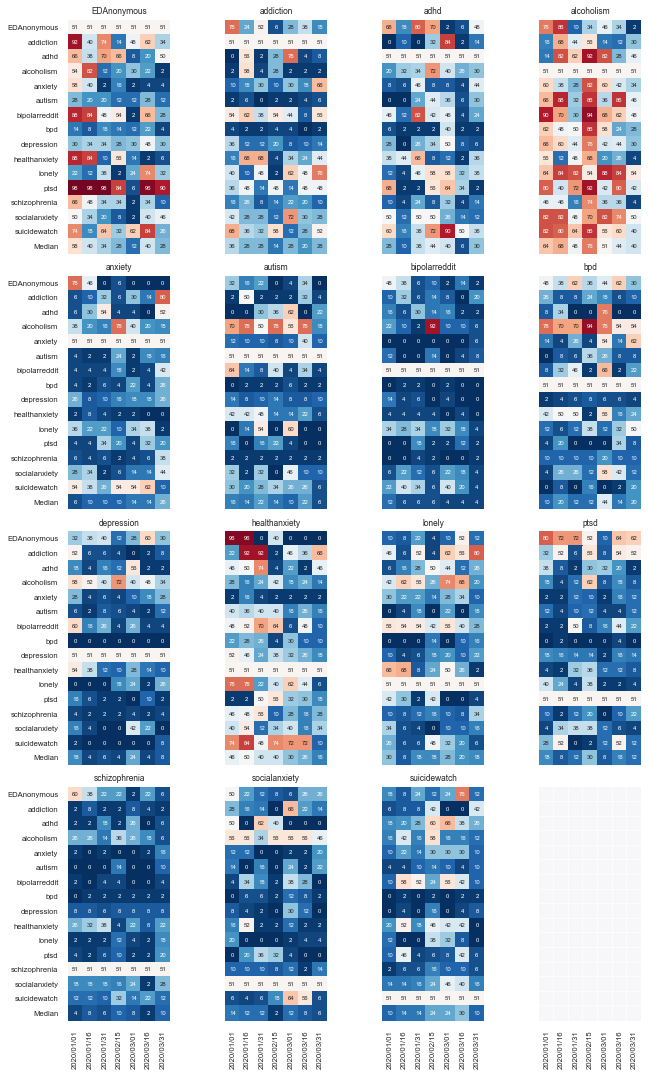

In [416]:

sns.set(font_scale=0.7)
fontsize = 6
dpi=100
savefig  =True
plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15))
axes = [n for i in axes for n in i]

median_percentiles ={}

for i, ax in enumerate(axes):
    print(i)
    if i in [15]:
        df = np.ones((len(subreddits),7))
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = np.ones(7)

        hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r', mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.set(adjustable='box', aspect='equal')
    else:
        sr = subreddits[i]
        df = pd.DataFrame(percentile_3D_by_subreddit[i], columns = timesteps, index=subreddits)
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = df.median()
        median_percentiles[sr] = np.array(df.median())

        hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = 'RdBu_r', square=True, ax=ax, annot_kws={"fontsize":fontsize},
                        vmin=0, vmax=100)
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(sr)
        ax.set(adjustable='box', aspect='equal')


plt.tight_layout()
if savefig:
    plt.savefig(output_dir+f'/percentile_all.png', dpi=400)
    


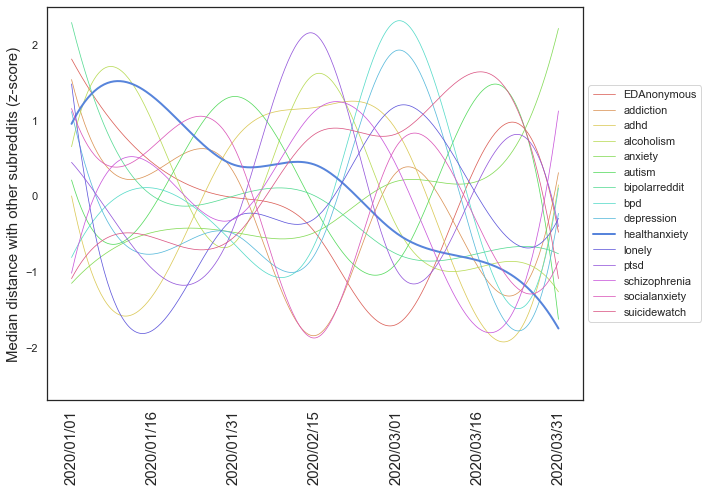

In [417]:
df = pd.DataFrame(median_percentiles)
df['timesteps'] = timesteps

from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline, BSpline

# color = 'husl' #hls husl
# palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.set(style='white', rc={'figure.figsize':(10,7)}, font_scale =1, palette=sns.color_palette("husl", 14))
pvals = []
fig, ax1 = plt.subplots()
for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)
    pvals.append(p_value)

    if sr == 'healthanxiety':
        alpha = 1
        linewidth = 2    
    else:
        alpha = 1
        linewidth = 0.75    
    xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
    spl = make_interp_spline(x_digits, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    color_i = next(palette)
    ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth, color=color_i)
#     ax1.plot(x, x_digits*slope + intercept, alpha=alpha, linewidth=linewidth,label = sr, color=color_i)

ax1.set_xticks(ticks=x_digits)
ax1.set_xticklabels(x, rotation=90, fontsize=15)
plt.ylim((-2.7,2.5))

#     sns.lineplot(x, y,alpha=alpha)
    
        
        
# for sr, y, x_name, x in covid_mentions:
#     x = list(x)
#     xnew = np.linspace(np.min(x), np.max(x), 300)  
#     spl = make_interp_spline(x, y, k=3)  # type: BSpline
#     power_smooth = spl(xnew)
#     alpha=0.6
#     linewidth = 1
#     if sr in subreddits_highlight:
#         alpha=1
#         linewidth = 3
#     ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)
    
#     spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
#     power_smooth = spl(xnew)
#     ax1.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0, c = 'k')
    
    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Median distance with other subreddits (z-score)', fontsize=15)
plt.xticks(rotation=90)
# plt.yticks(fontsize=1.2)
plt.tight_layout()


# from statsmodels.stats.multitest import multipletests
# reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
# print(reject, pvals_corrected)

plt.savefig(output_dir+'median_percentile_distance_curves', dpi=400)

[False False False False False False False False False  True False False
 False False False] [0.43671954 0.67840919 1.         0.37975423 0.08793608 0.70934856
 0.12220104 0.70934856 1.         0.01359452 1.         1.
 0.90087567 0.43671954 0.67840919]


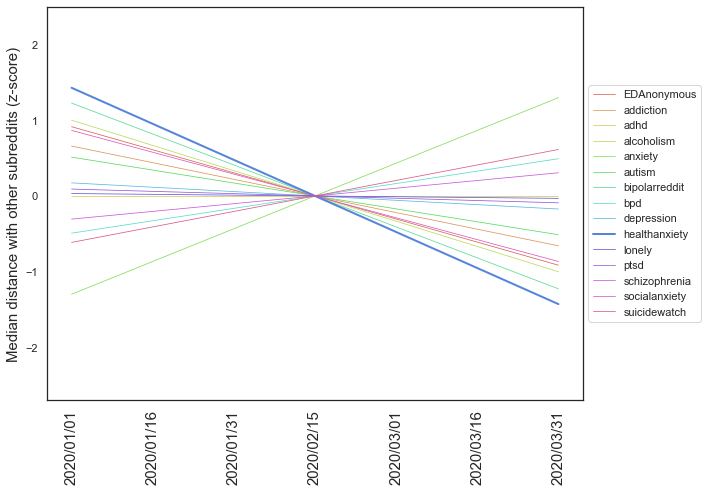

In [418]:
df = pd.DataFrame(median_percentiles)
df['timesteps'] = timesteps

from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline, BSpline

# color = 'husl' #hls husl
# palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.set(style='white', rc={'figure.figsize':(10,7)}, font_scale =1, palette=sns.color_palette("husl", 14))
pvals = []
fig, ax1 = plt.subplots()
for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)
    pvals.append(p_value)

    if sr == 'healthanxiety':
        alpha = 1
        linewidth = 2    
    else:
        alpha = 1
        linewidth = 0.75    
    xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
    spl = make_interp_spline(x_digits, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    color_i = next(palette)
#     ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth, color=color_i)
    ax1.plot(x, x_digits*slope + intercept, alpha=alpha, linewidth=linewidth,label = sr, color=color_i)

ax1.set_xticks(ticks=x_digits)
ax1.set_xticklabels(x, rotation=90, fontsize=15)
plt.ylim((-2.7,2.5))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Median distance with other subreddits (z-score)', fontsize=15)
plt.xticks(rotation=90)
plt.tight_layout()


from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(reject, pvals_corrected)

plt.savefig(output_dir+'median_percentile_distance_lines', dpi=400)

In [350]:
# # Percentiles with regards to 2019
# percentile_3D_by_timestep = []

# # for each timestep, obtain matrix of hausdorff distances      
# for timestep_df in results_i_dists_hausdorff:
#     # create empty matrix      
#     percentile_df = np.zeros(np.array(timestep_df).shape)
#     for row in range(timestep_df.shape[0]):
#         for col in range(timestep_df.shape[1]):
#             distance_2020 = np.array(timestep_df)[row,col]
#             distribution_2019 = dists_all[:,row,col]
#             percentile = stats.percentileofscore(distribution_2019, distance_2020)
#             percentile_df[row,col] = percentile
#     percentile_3D_by_timestep.append(percentile_df)    

# percentile_3D_by_timestep = np.array(percentile_3D_by_timestep)
    

## Output gif

In [ ]:
input_dir = '/Users/danielmlow/Dropbox (MIT)/libs/reddit/data/timestep_{}/'.format(timestep)
filenames = os.listdir(input_dir)
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)
import imageio
with imageio.get_writer(input_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)